<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import sys
import time

import seaborn as sns
import matplotlib.pyplot as plt

from pymystem3 import Mystem
import re 
import spacy
from nltk.corpus import wordnet
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import f1_score, roc_curve, roc_auc_score

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [4]:
data.sample(10)

,text,toxic
149567,"""\n\nPlease stop. If you continue to create in...",0
11583,Alright instead of citations and crap you shou...,0
110770,"Futurix, you have mistakenly presented an argu...",0
19504,""":::Thanks! Helpful. And, btw, I appreciate ...",0
150087,February 2009 \n Please stop your disruptive e...,0
81955,Sure Jimmy - plenty of info (and pictures) in ...,0
39202,"You advise is needed \n\nHello Roger,\n\nThis ...",0
107789,"""There you go. Thanks for spotting that! | ta...",0
155165,Many of us used to think of you guys as simply...,0
122545,"""\n\nI provided three cites that male tennis p...",0


In [5]:
data.duplicated().sum()

0

In [6]:
data.isna().sum()

text     0
toxic    0
dtype: int64

In [7]:
data['toxic'].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

<AxesSubplot:xlabel='toxic', ylabel='count'>

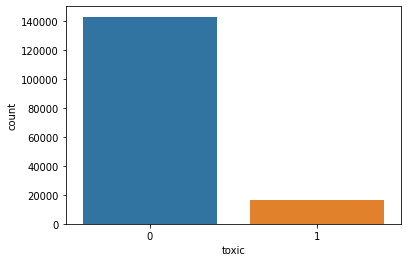

In [8]:
plt.figure(figsize=(6, 4))
sns.countplot(x='toxic', data=data)

plt.title("Распределение комментариев на позитивные и негативные")

Дисбаланс классов будем обрабатывает в процессе обучения

In [9]:
nlp = spacy.load('en_core_web_sm')

In [10]:
def lemma_clear(text): 

    lemm = nlp(text) 
    lemm = " ".join([token.lemma_ for token in lemm])  
    return " ".join(lemm.split())

In [15]:
%%time
data['text'] = data['text'].apply(lemma_clear)

CPU times: user 35min 51s, sys: 5.06 s, total: 35min 56s
Wall time: 35min 58s


In [40]:
data.sample(5)

,text,toxic
9403,the only problem be that you move the name to ...,0
156178,allen fyi here be one religious organisation s...,0
55101,btw this should answer the question as to whet...,0
134072,i take the definition from wikipedia article o...,0
157483,whoa that be even more ambitious p i prefer to...,0


**ВЫВОД 1**
На первом этапе данные были:
- проверены на наличие пропусков, 
- дублей, 
- изучен баланс классов, 
- лемматизирован,
- очищен текст. 

Далее подготовим данные и обучим модели 

## Обучение

In [49]:
#Переменные для признаков и целевого признака
features = data.drop(['toxic'], axis=1)
target = data['toxic']

#Деление на выборки
features_train, features_fv, target_train, target_fv = train_test_split(
    features, target, test_size=0.4, random_state=12345, stratify = target)

#Деление на выборки
features_test, features_valid, target_test, target_valid = train_test_split(
    features_fv, target_fv, test_size=0.5, random_state=12345)

print('Тренировочная выборка:', features_train.shape)
print('Валидационная выборка:', features_valid.shape)
print('Тестовая выборка:', features_test.shape)
print()
print('Целевой признак тренировочная выборки:', target_train.shape)
print('Целевой признак валидационной выборки:', target_valid.shape)
print('Целевой признак тестовой выборки:', target_test.shape)

Тренировочная выборка: (95575, 1)
Валидационная выборка: (31859, 1)
Тестовая выборка: (31858, 1)

Целевой признак тренировочная выборки: (95575,)
Целевой признак валидационной выборки: (31859,)
Целевой признак тестовой выборки: (31858,)


In [42]:
#Получение стоп-слов для английского языка
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [52]:
#Получение TF-IDF для корпуса текста
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

In [53]:
features_train = count_tf_idf.fit_transform(features_train['text'])

In [54]:
features_valid = count_tf_idf.transform(features_valid['text'])

In [55]:
features_test = count_tf_idf.transform(features_test['text'])

In [56]:
print("Размер матрицы train:", features_train.shape)
print("Размер матрицы valid:", features_valid.shape)
print("Размер матрицы test:", features_test.shape)

Размер матрицы train: (95575, 116359)
Размер матрицы valid: (31859, 116359)
Размер матрицы test: (31858, 116359)


**LogisticRegression**

In [59]:
pipeline = Pipeline([
    #('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('model', LogisticRegression(class_weight='balanced', random_state=12345, solver='liblinear'))])

params={'model__C':[.01,.05,.1,.5,1,5,10]}

grid = GridSearchCV(pipeline, cv=5, param_grid=params ,scoring='f1')

In [60]:
%%time
grid.fit(features_train, target_train)

CPU times: user 1min 51s, sys: 3min 26s, total: 5min 18s
Wall time: 5min 18s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=12345,
                                                           solver='liblinear'))]),
             param_grid={'model__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
             scoring='f1')

Best Grid: {'model__C': 10}
F1: 0.7636976962555222
AUC-ROC: 0.964903158188323


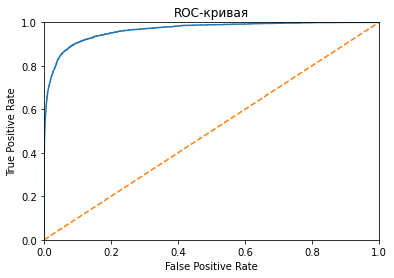

In [61]:
probabilities_valid = grid.predict_proba(features_valid)[:, 1]
probabilities_one_valid = probabilities_valid

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.plot([0, 1], [0, 1], linestyle='--')

auc_roc = roc_auc_score(target_valid, probabilities_valid)

print('Best Grid:', grid.best_params_)
print('F1:', grid.best_score_)
print("AUC-ROC:", auc_roc)

**DecisionTreeClassifier**

In [62]:
%%time

model = DecisionTreeClassifier(class_weight='balanced',
                               max_depth=20, random_state=12345,
                               min_samples_leaf=14)

model.fit(features_train, target_train)

scores = cross_val_score(model, 
                         features_train, 
                         target_train,
                         scoring='f1',
                         cv=5)

final_scor = scores.max()

print('F1:', final_scor)

F1: 0.6386850601702377
CPU times: user 1min 1s, sys: 145 ms, total: 1min 1s
Wall time: 1min 1s


**RandomForestClassifier**

In [63]:
%%time

model = RandomForestClassifier(class_weight='balanced', max_depth=20, random_state=12345, 
                              min_samples_leaf=10)

scores = cross_val_score(model, 
                         features_train, 
                         target_train,
                         scoring='f1',
                         cv=5)

final_scor = scores.max()

print('F1:', final_scor)

F1: 0.3997087732071351
CPU times: user 1min 58s, sys: 239 ms, total: 1min 58s
Wall time: 1min 58s


**BERT:** https://colab.research.google.com/drive/13kHHhpYMy8oEi3mX-9b2cWMsVLoALQ7h?usp=drive_link

**Тестирование модели**

In [64]:
%%time

predict = grid.predict(features_test)
print("F1:", f1_score(target_test, predict))

F1: 0.7695645884565313
CPU times: user 8.41 ms, sys: 3.43 ms, total: 11.8 ms
Wall time: 14.4 ms


## Выводы

В рамках проета были прелставлены данные интернет-магазина «Викишоп». 

**Цель проекта:** обучить модель классифицировать комментарии на позитивные и негативные.

**Требования:** метрика качества F1 должна быть не меньше 0.75

**LogisticRegression:** F1 = 0.76

**RandomForestClassifier:** F1 = 0.39

**DecisionTreeClassifier:** F1 = 0.61

**На Тесте:** F1 = 0.76

Наилучшее значение метрики F1 показала модель LogisticRegression